# Imports

In [89]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from numpy import std, mean, sqrt
import statsmodels.api as sm

In [90]:
%matplotlib inline

# Data Import & Cleaning

## Import

In [91]:
activities = pd.read_csv('./data/activities.csv')
sleep = pd.read_csv('./data/sleep.csv')

In [92]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 9 columns):
Start Time              41 non-null object
End Time                41 non-null object
Minutes Asleep          41 non-null int64
Minutes Awake           41 non-null int64
Number of Awakenings    41 non-null int64
Time in Bed             41 non-null int64
Minutes REM Sleep       30 non-null float64
Minutes Light Sleep     30 non-null float64
Minutes Deep Sleep      30 non-null float64
dtypes: float64(3), int64(4), object(2)
memory usage: 3.0+ KB


In [93]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
Date                      54 non-null object
Calories Burned           54 non-null int64
Steps                     54 non-null int64
Distance                  54 non-null float64
Floors                    54 non-null int64
Minutes Sedentary         54 non-null int64
Minutes Lightly Active    54 non-null int64
Minutes Fairly Active     54 non-null int64
Minutes Very Active       54 non-null int64
Activity Calories         54 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 4.3+ KB


In [94]:
sleep.index = pd.to_datetime(sleep['Start Time']).dt.date
sleep.index = pd.to_datetime(sleep.index)
sleep.index.name = 'Date'

In [95]:
activities.loc[:, 'Date'] = pd.to_datetime(activities['Date'])
activities = activities.set_index('Date', drop=True)

## Clean

Remove the empty values from the sleep data and join the data sets retaining only the dates for which there is full information.

In [96]:
sleep = sleep.dropna(how='any')

In [97]:
data = activities.merge(sleep, how='inner', left_index=True, right_index=True)

Let's add ratios for the sleep-stage variables and remove some of the columns we don't need.

In [98]:
data['light_sleep_ratio'] = data['Minutes Light Sleep'] / data['Minutes Asleep']
data['deep_sleep_ratio'] = data['Minutes Deep Sleep'] / data['Minutes Asleep']
data['rem_sleep_ratio'] = data['Minutes REM Sleep'] / data['Minutes Asleep']
data.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories', 'Start Time', 'End Time',
       'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
       'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep',
       'Minutes Deep Sleep', 'light_sleep_ratio', 'deep_sleep_ratio',
       'rem_sleep_ratio'],
      dtype='object')

# T-Test

Split the data into cardio and weights samples and perform a Student t-test on the deep_sleep_ratio variable.

In [99]:
cardio_s = data.loc[:'2019-03-30']
weights_s = data.loc['2019-03-30':]
print(len(cardio_s), len(weights_s))

14 15


In [100]:
weights_s = weights_s.iloc[:-1]  # to allow for within-subject t-test

## Explore

In [101]:
cardio_s_deep = cardio_s['deep_sleep_ratio']
weights_s_deep = weights_s['deep_sleep_ratio']

In [102]:
pd.DataFrame(data=[cardio_s_deep.values, weights_s_deep.values], index=['cardio', 'weights']).T.describe()

,cardio,weights
count,14.000000,14.000000
mean,0.203872,0.150810
std,0.030958,0.035051
min,0.160714,0.089130
25%,0.184589,0.128564
50%,0.196541,0.158867
75%,0.220668,0.174803
max,0.263415,0.199475


The mean deep-sleep ratio is 5% higher for the days with cardio workouts than those with weight-lifting. The standard deviations of the two groups are comperable.

Let's see if the difference is statistically significant.

In [103]:
t, p = ttest_rel(cardio_s_deep, weights_s_deep)
print('t(14)={:.2f}, p={:.4f}'.format(t, p))

t(14)=4.49, p=0.0006


In [104]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(
        ((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof
    )

In [105]:
cohen_d(cardio_s_deep, weights_s_deep)

1.6046461510717354

The difference observed between the two workouts seems to be statistically significant with a p<.001 and an impressive Cohen's d value of 1.62.

# Linear Model

Let's dive deeper and see if we cean further tease apart the workout intensities and if we can derive a linear model predicting the ratio of deep sleep following a given workout session.

## Exploration

In [106]:
interesting_cats = data.loc[:, [
    'Calories Burned', 'Steps', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active',
    'Minutes Fairly Active', 'Minutes Very Active', 'Activity Calories', 'Minutes Asleep', 
    'light_sleep_ratio', 'deep_sleep_ratio', 'rem_sleep_ratio'
]]

In [107]:
interesting_cats.describe()

,Calories Burned,Steps,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep,light_sleep_ratio,deep_sleep_ratio,rem_sleep_ratio
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2313.379310,6129.517241,19.241379,840.137931,166.655172,12.000000,19.103448,824.655172,401.965517,0.546756,0.176692,0.276552
std,247.393182,3320.188147,13.852940,196.809503,44.815715,10.973995,19.282384,305.879911,42.863140,0.066587,0.041611,0.038926
min,1793.000000,1315.000000,7.000000,358.000000,64.000000,0.000000,0.000000,221.000000,342.000000,0.371345,0.089130,0.210227
25%,2152.000000,3794.000000,12.000000,735.000000,134.000000,0.000000,0.000000,612.000000,381.000000,0.511299,0.158537,0.250000
50%,2304.000000,5700.000000,14.000000,807.000000,162.000000,12.000000,15.000000,832.000000,410.000000,0.549618,0.180180,0.277500
75%,2495.000000,8493.000000,17.000000,883.000000,199.000000,19.000000,32.000000,1041.000000,416.000000,0.583924,0.199475,0.302663
max,2726.000000,13146.000000,64.000000,1376.000000,252.000000,40.000000,63.000000,1302.000000,555.000000,0.657289,0.263415,0.371345


I typically spend 17.67% of my sleep in the deep-sleep stage, with an average deviation from that mean of 4.16%.

In [108]:
interesting_cats.corr().where(interesting_cats.corr() > .7)

,Calories Burned,Steps,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Minutes Asleep,light_sleep_ratio,deep_sleep_ratio,rem_sleep_ratio
Calories Burned,1.000000,0.894639,NaN,NaN,0.724174,0.725167,0.711023,0.988429,NaN,NaN,NaN,NaN
Steps,0.894639,1.000000,0.730826,NaN,NaN,NaN,0.798883,0.903977,NaN,NaN,NaN,NaN
Floors,NaN,0.730826,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minutes Sedentary,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minutes Lightly Active,0.724174,NaN,NaN,NaN,1.000000,NaN,NaN,0.769719,NaN,NaN,NaN,NaN
Minutes Fairly Active,0.725167,NaN,NaN,NaN,NaN,1.000000,NaN,0.741667,NaN,NaN,NaN,NaN
Minutes Very Active,0.711023,0.798883,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Activity Calories,0.988429,0.903977,NaN,NaN,0.769719,0.741667,NaN,1.000000,NaN,NaN,NaN,NaN
Minutes Asleep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
light_sleep_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


The deep sleep ratio doesn't seem to be correlated with any of the activity-level measures.

### Graphical Exploration

I will explore more than the deep sleep variable out of curiocity and to inform potential future studies.

#### Activity Measures

Let's check how the graphs look for the activity measures.

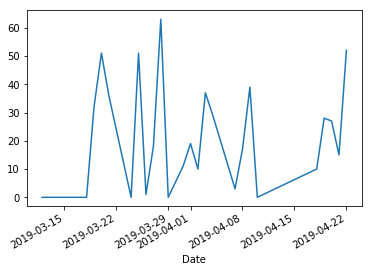

In [109]:
data.loc[:, 'Minutes Very Active'].plot()

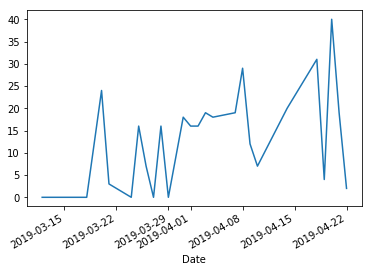

In [110]:
data.loc[:, 'Minutes Fairly Active'].plot()

There seems to be a decrease in overall Minutes Very Active and an increase in the Minutes Fairly Active spot-on at the mark of March 30th, which is when I switched from cardio-based cutting workouts to a weights-based bulking routine. There might be something there.

#### Sleep Measures

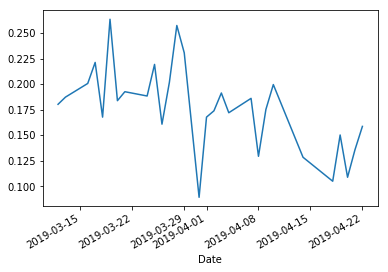

In [111]:
data.loc[:, 'deep_sleep_ratio'].plot()

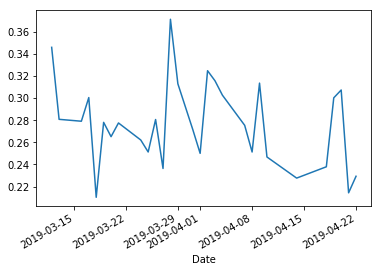

In [112]:
data.loc[:, 'rem_sleep_ratio'].plot()

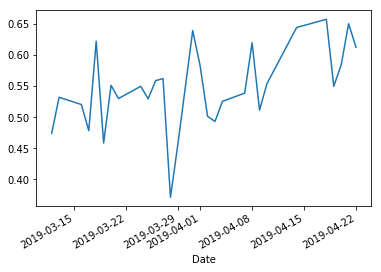

In [113]:
data.loc[:, 'light_sleep_ratio'].plot()

There is a slight decrease in the ratio of deep sleep that matches well with the change in workout routine.

## Analysis

Let's see if we can fit a model to the the activity measures and deep sleep.

In [114]:
data.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories', 'Start Time', 'End Time',
       'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
       'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep',
       'Minutes Deep Sleep', 'light_sleep_ratio', 'deep_sleep_ratio',
       'rem_sleep_ratio'],
      dtype='object')

I am interested in the minutes of activity. Excluding minutes of inactivity will allow me to not scale the inputs as the minutes of activity measures are on the same scale, allowing me to get a good idea of the contribution of one minute of a given level activity on the time spent in deep sleep.

In [115]:
X = data.loc[:, [
    'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active'
]]
y = data.loc[:, 'deep_sleep_ratio']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const)
res = model.fit()

In [116]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       deep_sleep_ratio   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     5.486
Date:                Thu, 02 May 2019   Prob (F-statistic):            0.00490
Time:                        14:53:21   Log-Likelihood:                 58.896
No. Observations:                  29   AIC:                            -109.8
Df Residuals:                      25   BIC:                            -104.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2028      0.027      7.576      0.000       0.148       0.258
Minutes Lightly Active    -0.0001      0.000     -0.582      0.566      -0.000       0.000
Minutes Fairly Active     -0.0021      0.001     -2.798      0.010      -0.004      -0.001
Minutes Very Active        0.0008      0.000      2.396      0.024       0.000       0.002
==============================================================================
Omnibus:                        0.480   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.043
Skew:                          -0.077   Prob(JB):                        0.979
Kurtosis:                       3.110   Cond. No.                         733.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An ANOVA on the model reveals that Minutes Fairly Active has a statistically significant negative effect on the ratio of deep sleep, reducing it by .2% for every minute of fair activity. On the other hand, high activity seems to increase the deep sleep ratio by .08% for every minute of high-intensity activity, and the effect is also statistically significant.

Light activity levels have no significant effects on the deep sleep ratio.